<a href="https://colab.research.google.com/github/alboyaci/olive_yield_detection/blob/main/trainmain.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [16]:
 import os
os.chdir('/content/drive/My Drive/tez-cengiz')

In [17]:
pwd

'/content/drive/My Drive/tez-cengiz'

In [18]:
import tensorflow as tf
from tensorflow.keras import models, layers, backend
import matplotlib.pyplot as plt
from IPython.display import HTML

In [19]:
print(tf.version)

<module 'tensorflow._api.v2.version' from '/usr/local/lib/python3.10/dist-packages/tensorflow/_api/v2/version/__init__.py'>


In [20]:
BATCH_SIZE = 32
IMAGE_SIZE = 224
CHANNELS=3
EPOCHS=50

In [24]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "Datasets/dataset2/",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 954 files belonging to 2 classes.


In [ ]:
HTML("""
<iframe width="560" height="315" src="https://www.youtube.com/embed/VFEOskzhhbc" title="YouTube video player" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>
""")

In [25]:
class_names = dataset.class_names
class_names

['hastalıklı', 'sağlam']

In [26]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 224, 224, 3)
[0 1 0 1 0 1 0 1 0 1 1 0 1 1 0 1 1 1 1 1 0 1 0 0 0 1 0 0 0 0 1 0]


In [27]:
backend.clear_session()

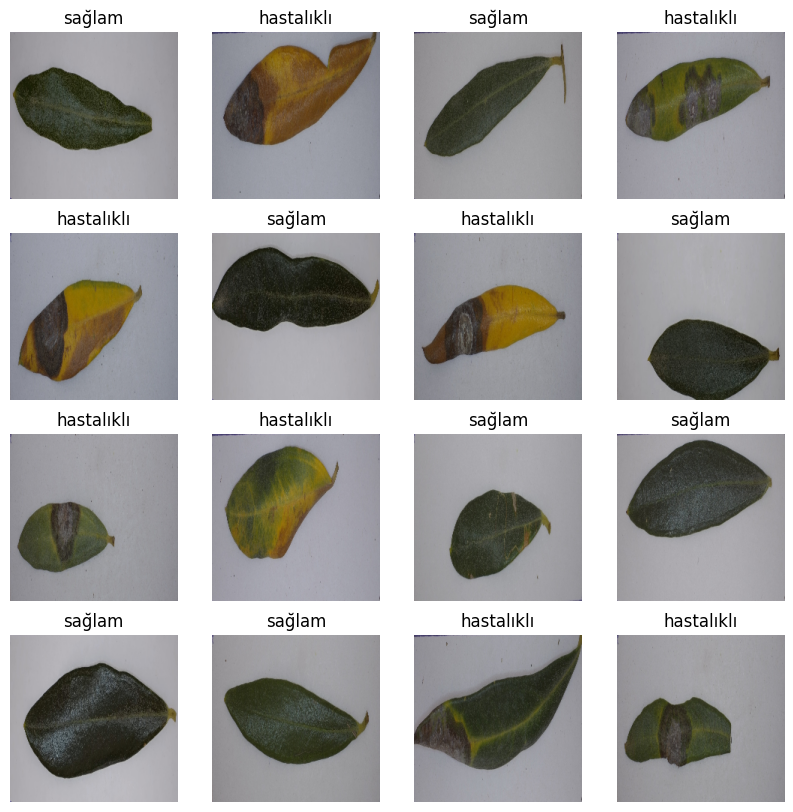

In [28]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(16):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [29]:
len(dataset)

30

In [30]:
train_size = 0.8
len(dataset)*train_size

24.0

In [31]:
train_ds = dataset.take(54)
len(train_ds)

30

In [32]:
test_ds = dataset.skip(54)
len(test_ds)

0

In [33]:
val_size=0.1
len(dataset)*val_size

3.0

In [34]:
val_ds = test_ds.take(6)
len(val_ds)

0

In [35]:
test_ds = test_ds.skip(6)
len(test_ds)

0

In [36]:

def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [37]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [38]:
len(train_ds)

24

In [39]:
len(val_ds)

3

In [40]:
len(test_ds)

3

In [41]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [42]:

resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [43]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [44]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [45]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [46]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 224, 224, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 222, 222, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 111, 111, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 109, 109, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 54, 54, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (32, 52, 52, 64)         

In [47]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [48]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
)

Epoch 1/50
24/24 [==============================] - 152s 1s/step - loss: 0.7570 - accuracy: 0.5276 - val_loss: 0.6742 - val_accuracy: 0.6354
Epoch 2/50
24/24 [==============================] - 5s 205ms/step - loss: 0.6767 - accuracy: 0.5722 - val_loss: 0.6696 - val_accuracy: 0.6354
Epoch 3/50
24/24 [==============================] - 6s 232ms/step - loss: 0.6391 - accuracy: 0.6299 - val_loss: 0.6894 - val_accuracy: 0.6875
Epoch 4/50
24/24 [==============================] - 5s 204ms/step - loss: 0.5045 - accuracy: 0.7205 - val_loss: 0.4589 - val_accuracy: 0.7917
Epoch 5/50
24/24 [==============================] - 6s 246ms/step - loss: 0.4031 - accuracy: 0.8110 - val_loss: 0.4076 - val_accuracy: 0.8125
Epoch 6/50
24/24 [==============================] - 5s 202ms/step - loss: 0.3923 - accuracy: 0.8097 - val_loss: 0.4321 - val_accuracy: 0.8438
Epoch 7/50
24/24 [==============================] - 6s 256ms/step - loss: 0.3823 - accuracy: 0.8136 - val_loss: 0.5164 - val_accuracy: 0.8438
Epoch 8

In [49]:
backend.clear_session()

In [50]:
scores = model.evaluate(test_ds)

3/3 [==============================] - 28s 25ms/step - loss: 0.2519 - accuracy: 0.9222


In [51]:
scores

[0.2519006133079529, 0.9222221970558167]

In [52]:
history

In [53]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 24}

In [54]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [55]:
type(history.history['loss'])

list

In [56]:
len(history.history['loss'])

50

In [57]:
history.history['loss'][:5] # show loss for first 5 epochs


[0.7570019960403442,
 0.6767116785049438,
 0.6391315460205078,
 0.5044501423835754,
 0.4030984938144684]

In [58]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

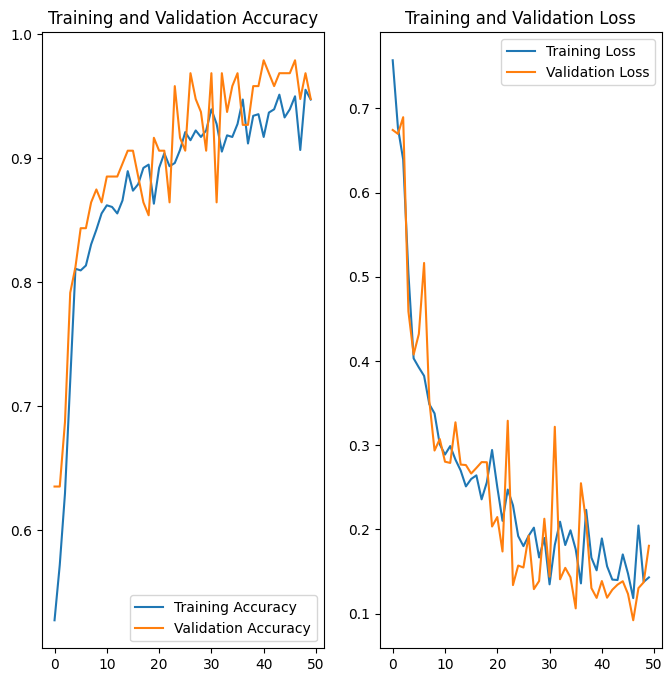

In [59]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: hastalıklı
1/1 [==============================] - 0s 115ms/step
predicted label: sağlam
first image to predict
actual label: hastalıklı
1/1 [==============================] - 0s 34ms/step
predicted label: hastalıklı


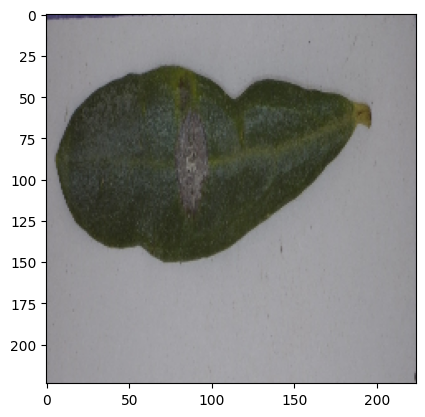

In [61]:
import numpy as np
for images_batch, labels_batch in test_ds.take(2):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [62]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 20ms/step


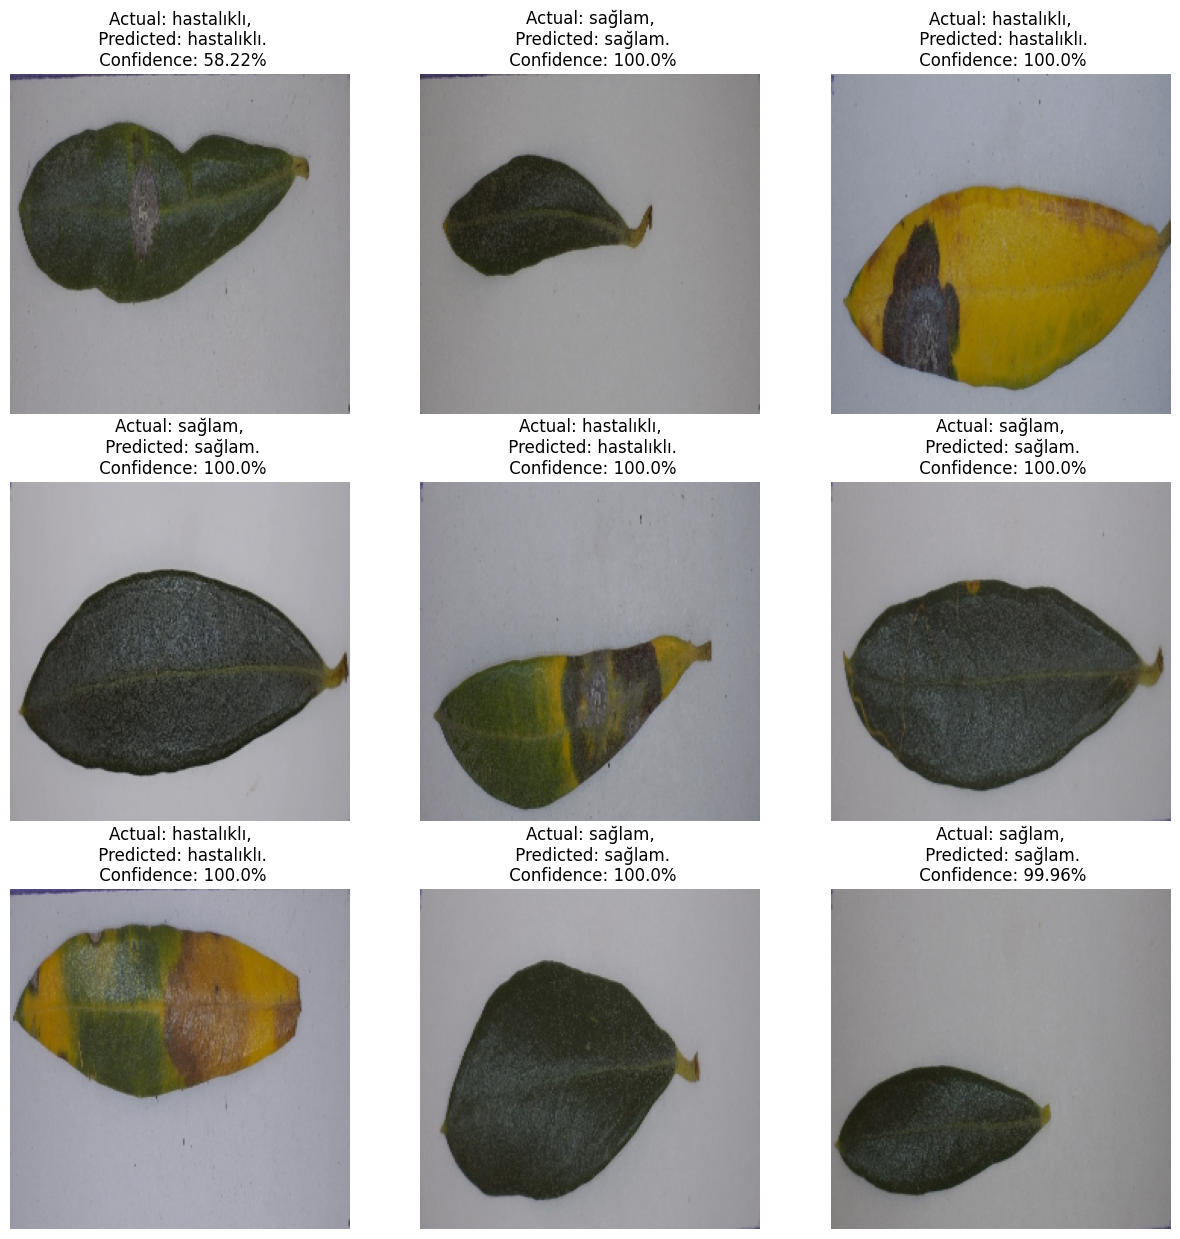

In [63]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")

In [64]:
import os
model_version=max([int(i) for i in os.listdir("../models") + [0]])+1
model.save(f"../models/{model_version}")


FileNotFoundError: [Errno 2] No such file or directory: '../models'

In [ ]:
model.save("../olive.h5")